In [2]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import sys
sys.path.append('/Users/allen/Documents/Python/geoPackage')
from geoPackage.io import ReadFile
from geoPackage.raster import Geoprocess
import matplotlib.pyplot as plt
from dataprocess import PixelTS
from osgeo import gdal
from affine import Affine

In [3]:
gauge_loc= gpd.read_file('../NCEP_gauge_locations.shp')
gauge_dir= '../rainfall_analysis/validationSet'
fs= [f for f in os.listdir(gauge_dir) if f.endswith('.txt')]

### Prepare gauge point estimation

In [5]:
with open(os.path.join(gauge_dir,fs[0]), 'r') as f:
    data= f.readlines()

In [4]:
data= [line.split() for line in data]

In [74]:
import datetime

In [114]:
def makeData(fname):
    
    with open(os.path.join(gauge_dir, fname), 'r') as f:
        data= f.readlines()
    print(data)
    data= [line.split() for line in data]
#     print(data)
    df= pd.DataFrame(data)
#     print(df.columns)
    df.columns= ['year', 'month', 'day', 'hour', 'minute', 'siteID', 'type', 'rain']
    new_df= pd.DataFrame()
    for site in list(set(df.siteID)):
        if (gauge_loc.iloc[:,1]==site).any():
#             print('one event')
            subset= df.loc[df.siteID==site, :].sort_values('hour')
            datetime= ['%04d'%int(subset.iloc[i].year) + '%02d'%int(subset.iloc[i].month)+ '%02d'%int(subset.iloc[i].day)+
                       '%02d'%int(subset.iloc[i].hour) for i in range(len(subset))]
#             print(datetime)
            datetime= pd.to_datetime(datetime, format='%Y%m%d%H')
#             print(datetime)
            date= datetime[0].strftime('%Y%m%d')
            subset.index= datetime
            _df= pd.DataFrame(index= pd.date_range(start= date, end= pd.to_datetime(date, format= '%Y%m%d')+pd.Timedelta('1 day'),
                                                                    freq= 'H', closed='left'), columns=[subset.siteID.values[0]])
            _df.loc[datetime, subset.siteID.values[0]]= subset.rain
            new_df= pd.concat([new_df, _df], axis=1)
            
#             datetime= [pd.to_datetime('%s%s%s%s'%(subset.iloc[i,:].year,
#                                                   subset.iloc[i,:].month,
#                                                   subset.iloc[i,:].day,
#                                                   subset.iloc[i,:].hour),
#                                       format='%Y%m%d%H') for i in range(len(subset))]
#             _df= pd.DataFrame(index= datetime)
#             _df[site]= subset['rain']
#             new_df= pd.concat([new_df, _df], axis=1)
            
        
    return new_df

In [117]:
df = pd.DataFrame()
for csv in fs:
    _df= makeData(csv)
    df= pd.concat([df, _df])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit

In [121]:
df.to_csv('gaugeRefData.csv')

In [127]:
gauge_loc[gauge_loc.iloc[:,1].isin(df.columns)].to_file('gaugeCropped.shp')

### prepare products point extraction

In [4]:
def qualityControl(ref):
    '''
    select criteria:
    1. Nan value takes more than 40%
    2. 0 values takes more than 60%
    ''' 

    for col in ref.columns:
        if ref[col].isna().sum()> 0.4*len(ref) or (ref[col].values==0).sum()> 0.6*len(ref):
            ref.drop(col, axis=1, inplace= True)
    
    return ref

In [5]:
gaugeLoc= gpd.read_file('gaugeCropped.shp')

In [9]:
# df_radar.to_csv('radarPointData.csv')
# df_sat.to_csv('satellitePointData.csv')
# df_gauge.to_csv('gaugePointData.csv')
gaugeRef= pd.read_csv('gaugeRefData.csv')
df_radar= set_index(pd.read_csv('radarPointData.csv'))
df_sat= set_index(pd.read_csv('satellitePointData.csv'))
df_gauge= set_index(pd.read_csv('gaugePointData.csv'))
gaugeRef.time= pd.to_datetime(gaugeRef.time, format= '%Y%m%d %H:%M:%S')
gaugeRef.set_index('time', inplace=True)
gaugeRef.sort_index(inplace=True)
gaugeRef= qualityControl(gaugeRef)

In [10]:
gaugeRef.head()

,ANWT2,AQLT2,ASBL1,ATBT2,BAKT2,BHTA4,BPT,BWRT2,CFKT2,CGNT2,...,SOLT2,SSRT2,TBAT2,VCT,VRNL1,WCGL1,WCVT2,WSBT2,WVLT2,ZVLT2
time,,,,,,,,,,,,,,,,,,,,,
2015-06-16 00:00:00,0.0,0.0,NaN,0.0,0.00,0.00,0.00,0.0,0.0,NaN,...,0.01,0.0,0.0,0.0,NaN,0.0,0.09,0.00,0.0,0.0
2015-06-16 01:00:00,0.0,0.0,NaN,0.0,0.01,0.00,0.00,0.0,0.0,NaN,...,0.02,0.0,0.0,0.0,NaN,0.0,0.01,0.03,0.0,0.0
2015-06-16 02:00:00,0.0,0.0,NaN,0.0,0.00,0.00,0.00,0.0,0.0,NaN,...,0.01,0.0,0.0,0.0,NaN,0.0,0.00,0.00,0.0,0.0
2015-06-16 03:00:00,0.0,0.0,NaN,0.0,0.00,0.02,0.00,0.0,0.0,NaN,...,0.01,0.0,0.0,0.0,NaN,0.0,0.00,0.00,0.0,0.0
2015-06-16 04:00:00,0.0,0.0,NaN,0.0,0.00,0.01,0.01,0.0,0.0,NaN,...,0.01,0.0,0.0,0.0,NaN,0.0,0.00,0.02,0.0,0.0


In [11]:
gaugeLoc= gaugeLoc[gaugeLoc.iloc[:, 1].isin(gaugeRef.columns)]

In [12]:
gauge_rmse= gdal.Open('TCresults/rmse_gauge.tif').ReadAsArray()


,54695,ABEQ1,ABEE,field_4,AB,ABEE - AGD,ALBERTA EN,CA,7,WOS,field_11,KRF,08/25/2011,field_14,54.2772,-112.9655,geometry
5,47774,ASBL1,ABITA SPRINGS,ST. TAMMANY,LA,ABITA SPRINGS AT HWY 36,GAGE (ABITA RIVER #5) LOCATED ON ABITA RD. BRI...,US,2,WOS,LIX,ORN,12/14/2006,04/28/2016,30.4816,-90.0394,(POINT (-90.0394 30.4816))
52,7224,DCBL1,INNISWOLD,EAST BATON ROUGE,LA,DAWSON CREEK AT BLUE BONNET,DAWSON CREEK AT BLUE BONNET,US,2,WOS,LIX,ORN,04/04/1996,07/25/2002,30.3822,-91.0942,(POINT (-91.0942 30.3822))
81,14955,LCAL1,AYCOCK,CLAIBORNE,LA,LAKE CLAIBORNE,LAKE CLAIBORNE,US,2,WOS,SHV,ORN,03/03/1997,10/16/2002,32.7389,-92.9050,(POINT (-92.905 32.7389))
84,31512,LEVL1,LEESVILLE,VERNON,LA,VERNON - FTS,NEAR FT POLK IN KISATCHIE NATIONAL FOREST,US,2,WOS,LCH,ORN,04/13/2000,04/14/2000,31.0167,-93.1869,(POINT (-93.18689999999999 31.0167))
85,56527,LFDL1,DONALDSONVILLE,ASCENSION,LA,BAYOU LAFOURCHE AT DONALDSONVILLE,GAUGE LOCATED AT ALBERT STREET/LA HWY. 3089 BR...,US,2,WOS,LIX,ORN,01/03/2013,None,30.1008,-90.9933,(POINT (-90.9933 30.1008))
87,15397,LILL1,LILLIE,UNION,LA,"LITTLE CORNEY BAYOU NR LILLIE, LA","LITTLE CORNEY BAYOU NR LILLIE, LA",US,2,WOS,SHV,ORN,09/18/1997,08/29/2002,32.9292,-92.6328,(POINT (-92.6328 32.9292))
94,17050,MDLL1,MANDEVILLE,ST. TAMMANY,LA,MIDLAKE (LAKE PONTCHARTRAIN),"GAGE LOCATED 11.42SSW MANDEVILLE, LA ON CAUSEW...",US,2,WOS,LIX,ORN,06/30/1993,05/20/2016,30.1994,-90.1225,(POINT (-90.1225 30.1994))
118,47881,PPBL1,BOGALUSA,WASHINGTON,LA,PEARL RIVER AT POOLS BLUFF,"SITE LOCATED 5.84S OF BOGALUSA, LA AT POOLS B...",US,2,WOS,LIX,ORN,01/18/2007,None,30.7058,-89.8464,(POINT (-89.8464 30.7058))
148,42027,VRNL1,LEESVILLE,VERNON,LA,DOVE FIELD RAWS,RAWS SITE LOCATED 18 MILES SOUTHEAST OF LEESVI...,US,2,WOS,LCH,ORN,10/25/2004,None,31.0331,-92.9819,(POINT (-92.9819 31.0331))
154,29003,WCGL1,MONTEREY,CONCORDIA,LA,WILD COW BAYOU STRUCTURE,LAND SIDE AND RIVER SIDE,US,2,WOS,JAN,ORN,06/30/1993,01/17/2008,31.3561,-91.7392,(POINT (-91.7392 31.3561))


In [353]:
def xy2mn():
    global gaugeLoc
    geometries= [np.array(gaugeLoc.geometry[i]).squeeze() for i in range(len(gaugeLoc))]
    forward_transform= Affine.from_gdal(*gdal.Open('../cleaned/gauges/ST2gg2019091810.Grb.tif').GetGeoTransform())
    transformed= [~forward_transform * geometry for geometry in geometries]
    
    return zip(transformed, gaugeLoc.iloc[:,1])

In [371]:
stats= {}
i=0

for (pair, column) in xy2mn():
#         print(pair, column)
    if column in gaugeRef.columns:
        n,m = pair
        n,m= int(n), int(m)
        if m<208 and n<293:
            estimates= pd.DataFrame(PixelTS().singlePixel(m,n))
            estimates= estimates[estimates>=0]
            estimates.index= pd.to_datetime(estimates.index, format= '%Y%m%d%H')
            estimates.sort_index(inplace=True)
            ref= gaugeRef[column]
    #             ref.dropna(inplace=True)
    #         rmseRadar, maeRadar, rRadar= pairComparison(estimates.radar, ref)
    #         rmseGauge, maeGauge, rGauge= pairComparison(estimates.gauge, ref)
    #         rmseSat, maeSat, rSat= pairComparison(estimates.satellite, ref)
            estimates= estimates.loc[ref.index, :]
    #             print(ref)
            _data= np.zeros((3,2))
            _data[0,:]= pairComparison(estimates.radar, ref)
            _data[1,:]= pairComparison(estimates.gauge, ref)
            _data[2,:]= pairComparison(estimates.satellite, ref)
            if _data[0,0]<_data[2,0] and _data[2,0]< _data[1,0]:
                stats[column]= _data
    #             print(column)
    #             print(stats)
            i+=1
            print(i, flush=True)


1


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


2


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


3


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


4


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


5


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


6


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


7


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


8


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


9


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


10


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


11


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


12


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


13


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


14


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


15


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


16


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


17


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


18


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


19


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


20


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


21


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


22


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


23


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


24


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


25


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


26


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


27


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


28


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


29


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


30


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


31


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


32


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


33


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


34


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


35


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


36


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


37


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


38


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


39


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


40


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


41


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


42


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


43


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


44


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


45


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


46


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


47


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


48


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


49


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


50


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


51


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


52


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


53


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


54


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


55


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


56


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


57


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


58


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


59


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


60


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


61


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


62


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [365]:
gaugeLoc[gaugeLoc.iloc[:,1].isin(stats.keys())].to_file('consistentResults.shp')

In [372]:
len(stats)

7

In [345]:
RMSE= {
    'radar': [],
    'gauge' : [],
    'satellite': []
}
R = {    'radar': [],
    'gauge' : [],
    'satellite': []}
for key in stats.keys():
    RMSE['radar'].append(stats[key][0,0])
    RMSE['gauge'].append(stats[key][1,0])
    RMSE['satellite'].append(stats[key][2,0])
    if ~np.isnan(stats[key][0,-1]):
        R['radar'].append(stats[key][0,-1])
    if ~np.isnan(stats[key][1,-1]):
        R['gauge'].append(stats[key][1,-1])
    if ~np.isnan(stats[key][2,-1]):
        R['satellite'].append(stats[key][2,-1])

{'whiskers': [<matplotlib.lines.Line2D at 0x13d9b6450>,
 'caps': [<matplotlib.lines.Line2D at 0x13a38fa10>,
 'boxes': [<matplotlib.lines.Line2D at 0x13d9b6fd0>,
 'medians': [<matplotlib.lines.Line2D at 0x132c75290>,
 'fliers': [],
 'means': []}

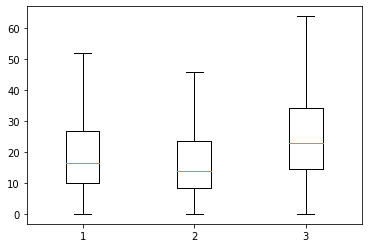

In [346]:
plt.boxplot([RMSE['radar'], RMSE['gauge'], RMSE['satellite']], showfliers=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x13a1bb290>,
 'caps': [<matplotlib.lines.Line2D at 0x1332d5b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x132c85450>,
 'medians': [<matplotlib.lines.Line2D at 0x13a6fded0>,
 'fliers': [],
 'means': []}

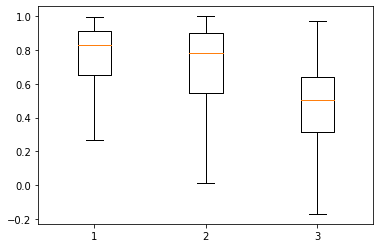

In [347]:
plt.boxplot([R['radar'], R['gauge'], R['satellite']], showfliers=False)

In [ ]:
gaugeGriddedData_pth= '../cleaned/gauges'
radarGriddedData_pth= '../cleaned/radars'
satGriddedData_pth= '../cleaned/satellites'



In [7]:
def set_index(df):
    df.rename(columns = {'Unnamed: 0': 'time'}, inplace= True)
    df.time= pd.to_datetime(df.time, format= '%Y%m%d%H')
    df.set_index('time', inplace=True)
    df.sort_index(inplace= True)
    
    return df

In [96]:
gaugeRef.rename(columns = {'Unnamed: 0': 'time'}, inplace= True)

In [102]:
gaugeRef.set_index('time', inplace=True)

In [59]:
gaugeRef.to_csv('gaugeRefData.csv')

In [114]:
df_radar= df_radar.loc[:,gaugeRef.columns]
df_sat= df_sat.loc[:,gaugeRef.columns]
df_gauge= df_gauge.loc[:,gaugeRef.columns]

In [116]:
colnames= [col for col in df_gauge.columns if df_gauge[col].isna().sum()<10]

In [118]:
df_radar= df_radar.loc[:, colnames]
df_gauge= df_gauge.loc[:, colnames]
df_sat= df_sat.loc[:, colnames]
gaugeRef= gaugeRef.loc[:, colnames]

In [125]:
df_radar.index= pd.to_datetime(df_radar.index, format= '%Y%m%d%H')
df_gauge.index= pd.to_datetime(df_gauge.index, format= '%Y%m%d%H')
df_sat.index= pd.to_datetime(df_sat.index, format= '%Y%m%d%H')

In [128]:
gaugeRef.head()

,ASBL1,DCBL1,LCAL1,LEVL1,LFDL1,LILL1,MDLL1,PPBL1,VRNL1,WCGL1
time,,,,,,,,,,
2017-08-26 00:00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2017-08-26 01:00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-26 02:00:00,0.0,0.01,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2017-08-26 03:00:00,0.0,0.02,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2017-08-26 04:00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


In [8]:
from scipy.stats import pearsonr
def pairComparison(x, y):
    common= (x>=0) & (y>=0)
    
    x= x[common]
    y= y[common]*22.4
    if len(x)>2 and len(y)>2:

        rmse= (((x-y)**2).sum()/len(x))**.5
        r2= pearsonr(x, y)[0]

        return rmse, r2
    else:
        return np.nan, np.nan

In [165]:
gaugeRef= gaugeRef.sort_index()
df_gauge= df_gauge.sort_index()
df_radar= df_radar.sort_index()
df_sat= df_sat.sort_index()

In [174]:
for col in gaugeRef.columns:
    ref= gaugeRef[col]
    gauge= df_gauge[col]
    radar= df_radar[col]
    sat= df_sat[col]
    ref= ref[gauge.index]
    
    print('gauge vs ref:\nRMSE    MAE     r:\n%.2f    %.2f .   %.2f'%(pairComparison(gauge, ref)[0], pairComparison(gauge, ref)[1], pairComparison(gauge, ref)[2]))

gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
gauge vs ref:
RMSE    MAE     r:
0.00    0.00 .   0.00
